## Copile, Package and Execute Non-Modular Java Applications
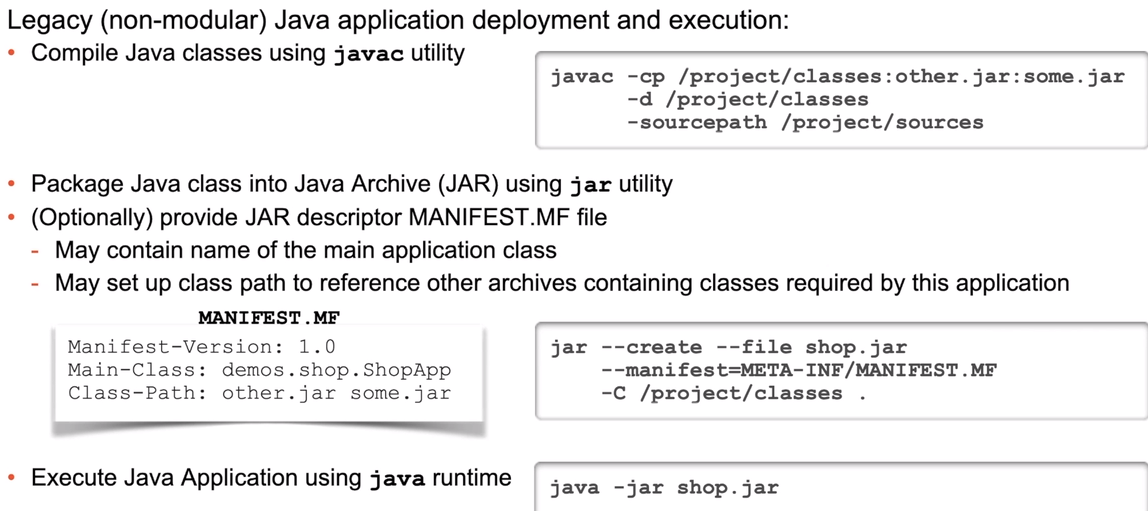

### Non-Modular Characteristics
- packages to provide logical grouping of classes
- packages do not provide physical restrictions on how they are used
    - `public` class is public to all other classes
    - no finer grain controll like _only access for package xyz_
- encapsulation cn always be bypassed by reflection    
- classes are placed in `jar` files and accessed via classpath
- deployment of related classes is not enforced
    - e.g. forgot to add classes to the jar
    - when loaded at runtime this will lead to a ClassNotFound exception

### Example
<img src=attachment:image.png width=600></img>
- class `Y` is package private
- class `Z` can't import it
- however, class `Z` can still access and use `Y` via the reflection API
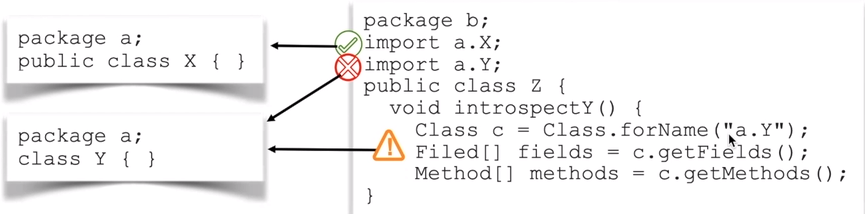

## Module
- Java Platform Module System (JPMS)
- high-level code aggregation
- contains
    - one ore more related packages
    - other resources like images or XML files


- module descriptor `module-info.class` (stored in the root folder of the module) contains
    - _unique module name_ (reverse-DNS convention is recommended e.g. `org.corp.ronny`)
    - _required module dependencies_ (other modules that this module depends on)
    - _packages_ that this module _exports_
        - _hidden by default_
        - must be explicitly exposed
        - makes them available for other modules
        - all other packages within that module are unavailable to other modules
    - _permissions_ to open content of this module to other modules using _reflection_
        - default is _deny reflection_
        - has to be explicitly allowed
    - _services_ that this module _offers_ to other modules
    - _services_ this modules _consumes_
    - modules don't allow splitting Java packages, even when they are private

<img src=attachment:image.png width=600></img>
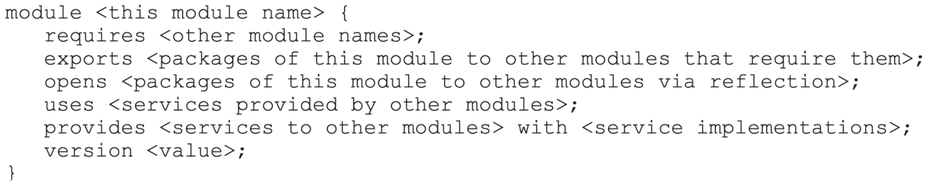

- from Java 9 on, all JDK APIs are modules
- note: 2 modules can't be in the same folder -> they would need to share on `module-info.java` descriptor file
- module name
    - unique
    - typically named after primary package contained within this module
- module declaring its dependencies (= which other modules are used)
    - enables smaller application deployment footprint
    - circular module dependencies are note allowed
    - dependencies between modules can be verified at startup
- classes inside a modularized application are loaded using _module-path_ - not class-path!
    - detects deployment errors at startup (e.g. missing classes)
    

### Quicker Startup time
- class path loader
    - scans the whole class path of classes
- with modules, the exact information of what is required is there
- in an app with many jars a modularized app can have a performance advantage

### JPMS Module Categories
- Java SE Modules
    - Core Java platform for general-purpose APIs
    - module name starts with _java_ like
        - `java.base`
        - `java.se`
        - `java.logging`
    
- JDK Modules
    - additional implementation-specific modules
    - depends on the provider of the JDK
    - module names start with _jdk_ like
        - `jdk.httpserver`
        - `jdk.jconsole`
        - `jdk.jshell`

- Other Modules
    - my own module using third party libs

```shell
$ java --list-modules

java.base@11.0.9
java.compiler@11.0.9
java.datatransfer@11.0.9
java.desktop@11.0.9
java.instrument@11.0.9
java.logging@11.0.9
java.management@11.0.9
java.management.rmi@11.0.9
java.naming@11.0.9
java.net.http@11.0.9
java.prefs@11.0.9
java.rmi@11.0.9
java.scripting@11.0.9
java.se@11.0.9
java.security.jgss@11.0.9
java.security.sasl@11.0.9
java.smartcardio@11.0.9
java.sql@11.0.9
java.sql.rowset@11.0.9
...
```

## Define Module Dependencies
- directive `required java.base` is implied for all modules
- contains most of the Java SE stuff

````java
module com.some {
    // - normal module dependency
    // - read: "com.some needs access to content 
    //   provided by java.logging module"
    requires java.logging;
    
    // - make dependend module available to other modules
    // - read: user of module com.some will also use org.acme 
    //   *without* having to declare an explicit dependency
    requires transitive org.acme;
    
    // - module dependency required only at compile time
    // - read: com.some optionally uses module com.foo; this usage is not required at run time
    requires static com.foo;
    
    // comma separated list allowed
    requires org.corp.peter, org.corp.klaus;
}    
````

## Export Module Content
- exporting = making all of its **public** types (including their nested public/ protected types) available to other modules
- `export <packages>` - list of packages whose public types should be accessible to all other modules
- `export <packages> to <other module>` - restricts exported packages to a list of specific modules

### Example
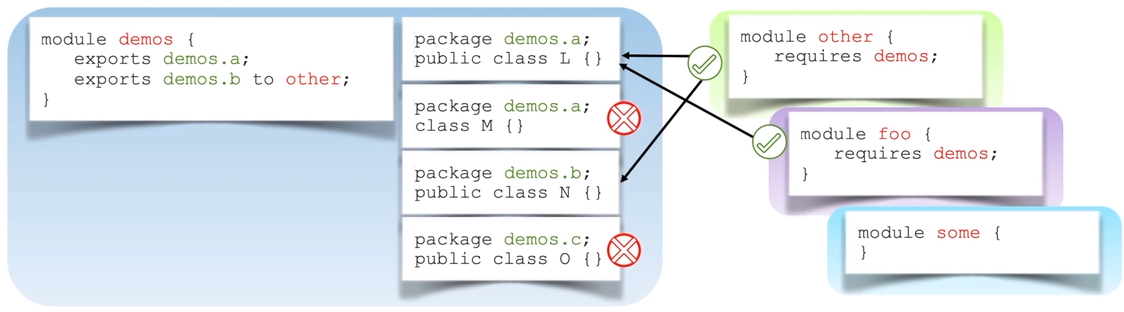

- invisible classes inside the `demos` package
    - class `demos.c.O` is not exported by the `demos` module
    - class `demos.a.M` is package protected     
- module `other`
    - can access class L because 
        - the package `demos.a` was exported
        - L is public
    - can access class N because 
        - the package `demos.b` was explicitly exported for "other"
        - N is public
- module `foo`
    - can access L because
        - the package `demos.a` was exported
        - L is public
- module `some`
    - can't use anything from any module since it does not _require_ anything

## Module Example
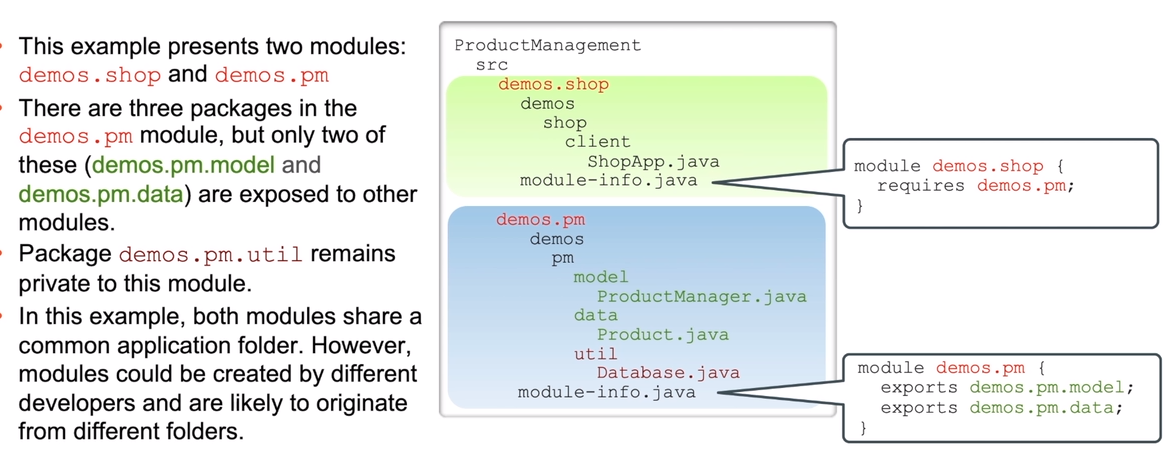

## Open Module Content

- alternative to `exports`
- allow content of a package to be used _including_ reflection API
- enable dependeny injection: modules containing injectable code should use "opens" > DI works via reflection


- `opens <package>` - specify package whose entire content is accessible to all other modules _at runtime_
- `opens <package> to <package name>` - same as above but restrict to list of specific modules

### Example
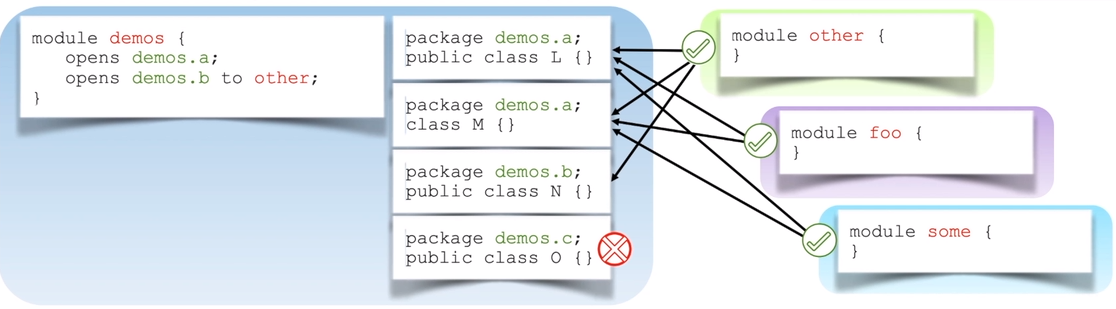
- package `demos.a` is "open" > class `demos.a.M` is accessible for all modules via reflection
- package `demos.c` is still not exposed to other modules and _remains private_

## Open Entire Module
- mimics non-modular Java behaviour
- `open module demos {}` in descriptor file
    - the module's entire content is accessible to all other modules at run time via reflection

## Produce & Consume Services
- describe _Abstract class_ or an _Interface_ which defines behaviour
- service also provides one or more implementations of that interface
- application uses interfaces, not implementation > DI


Syntax
- `provides <service interface> with <classes>`
    - module that provides implementations of interface (provider)
- `uses <service interface`
    - interface or abstract class that of a service which this module likes to use (consumer)  
    

- `ServiceLoader.load()` 
    - returns stream of providers found in the module path
    - pick your implementation

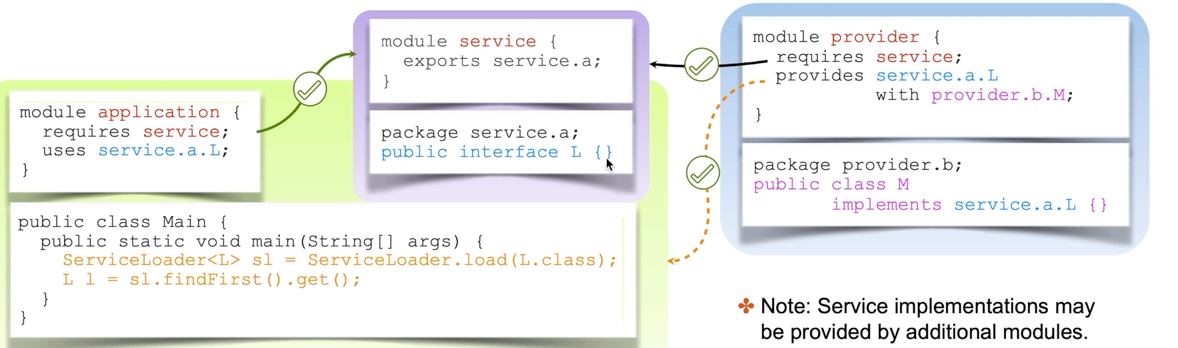

## TODO - Build example based on this
- make it a learning test
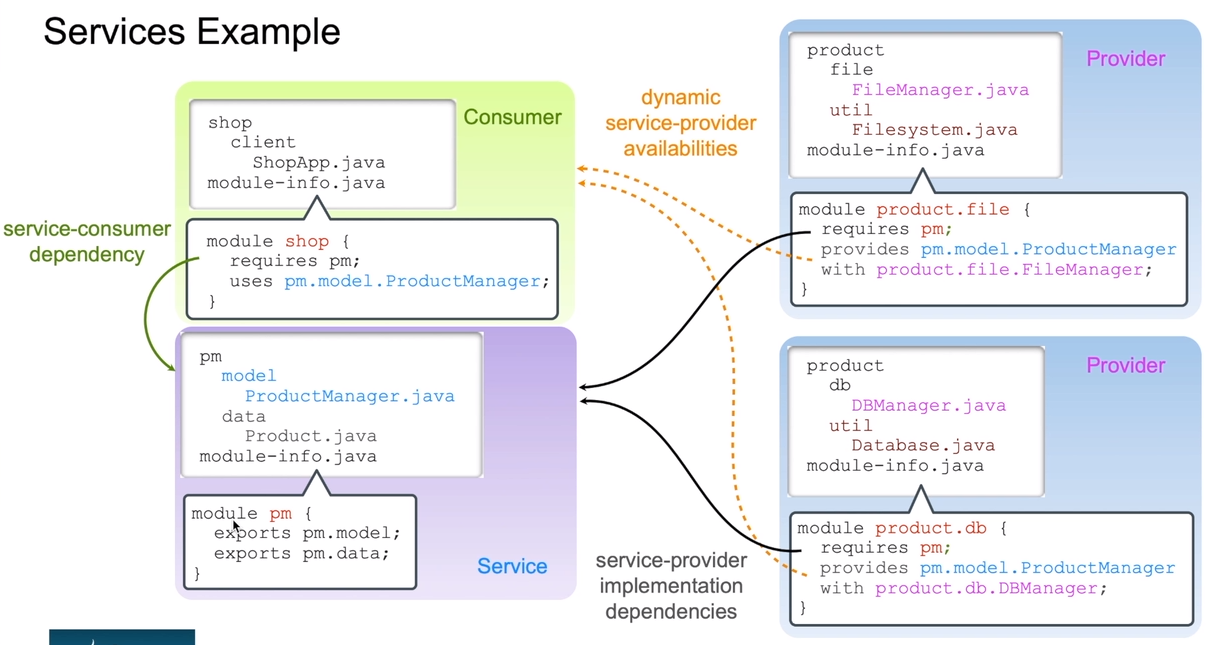

## Multi-Release Module Archives
- dealing with differing implementations for different Java versions
- issue: module path can contain only _one_ copy of a module
- solution
    - module can contain multiple implementations
    - module root dir may contain either default version or non-modularized version to be used for Java < 9
    - inside `META-INF` there can be directories for each supported Java version
    - versioned descriptors (module-info) 
        - optional
        - must be mainly identical to root module descriptor
        - exceptions allowd
            - different non-transitive `requires` clauses for _java.*_ and _jdk.*_ modules
            - different use clauses

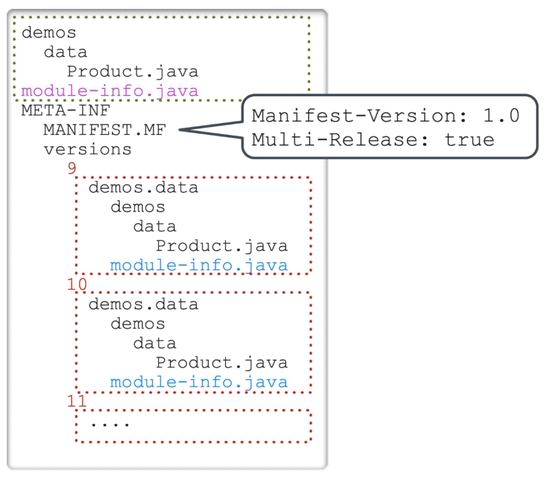

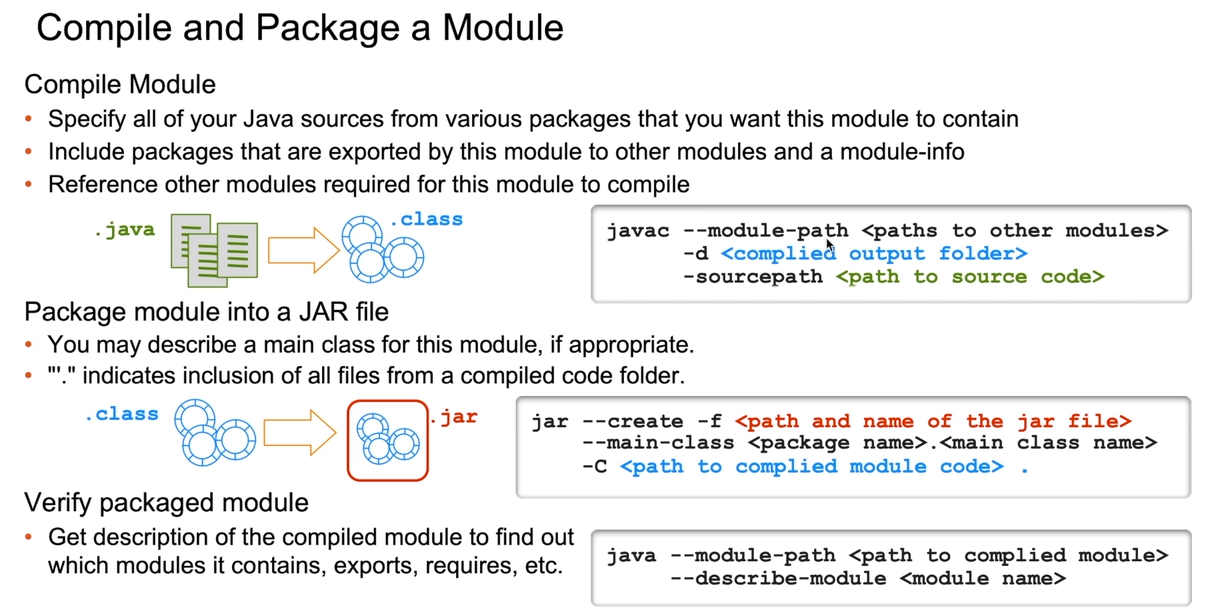

## Executing Modularized Application
- classes are located via `-p` or `--module-path`
- main class reference via `-m` or `--module`
- non-modular JARs are trated as _Automatic Modules_

### Run Modular App

```shell
java -p <path to module> -, <module name>/<package name>.<main class name> <arguments>
```

### Run Non-Modular App

```shell
java -cp <path to jars including modularized jars> <package name>.<main class name> <arguments>
```

Note: 
- in Java 9 onward, classes in `classpath` are assigned to _unnamed module_ 
- temp. solution for migrating to a modular application structure


## Automatic Module for Legacy Apps
- non-modular JARs are treated as _automatic modules_
- can be referenced like a module using `requires`
- by default _JAR file name_ is used for reference
- alternativly (avoid naming conflicts) _Automatic-Module-Name_  can be specified in the _MANIFEST.MF_ file
<img src=attachment:image.png width=500></img>
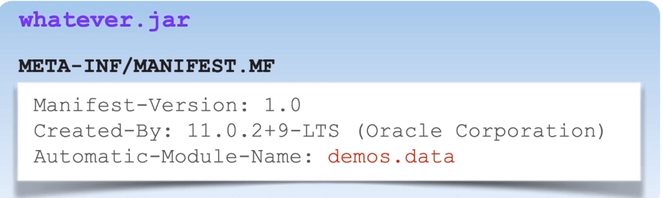

## Create Custom Runtime Image with jlink

### TODO try this out (learning test)

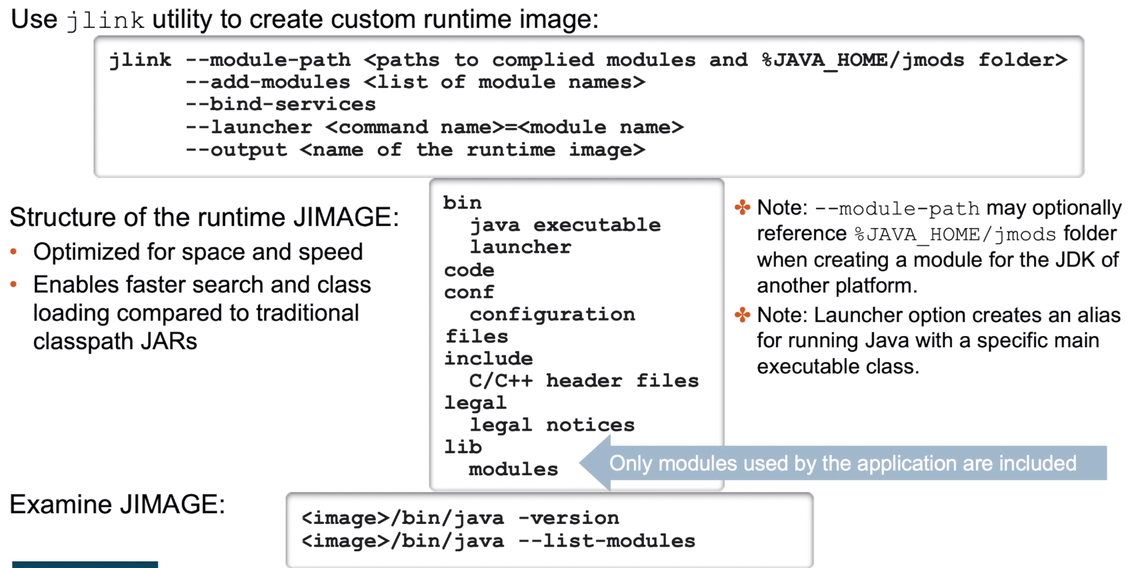

### Execute Image
```
<image>/bin/java -m <module name>
```

or with launcher provided

```
<image>/bin/<command name>
```

## Cheat Sheet
[Cheat Sheet](java-9-modules-cheat-sheet.pdf)